_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: Luca Kosina, Max Bardelang, Sascha Mühlinghaus

LLM Disclaimer: Copilot for commenting and ChatGPT for help with interpreting plots.

# Coding Lab 2

## Introduction

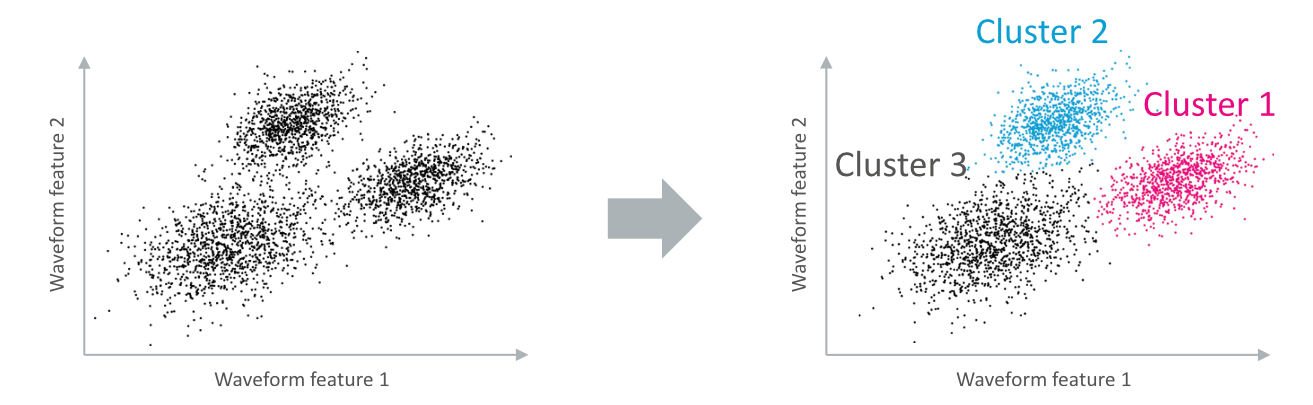

In this coding lab, we continue with the x from the first coding lab and finalize the Spike Sorting pipeline.
In particular, we use the created feature space to identify individual clusters by fitting a Gaussian Mixture Model.
To verify that this model does what we want, we first create a synthetic Toy Dataset and apply the model to that.

- __Data__: Use the saved data `nds_cl_1_*.npy` from Coding Lab 1. Or, if needed, download the data files ```nds_cl_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

In [11]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from __future__ import annotations

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-05-04 22:09:02CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.1.0

sklearn: 1.6.1

matplotlib: 3.10.1
sklearn   : 1.6.1
scipy     : 1.15.2
numpy     : 2.2.5

Watermark: 2.5.0



In [12]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [13]:
# replace by path to your solutions
b = np.load("../data/nds_cl_1_featuresnpy.sec")
s = np.load("../data/nds_cl_1_spiketimes_snpy.sec")
t = np.load("../data/nds_cl_1_spiketimes_tnpy.sec")
w = np.load("../data/nds_cl_1_waveformsnpy.sec")

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 2 pts*


In [14]:
def sample_data(
    n_samples: int, m: np.ndarray, S: np.ndarray, p: np.ndarray, random_seed: int = 0
) -> tuple[np.ndarray, np.ndarray]:
    """Generate n_samples samples from a Mixture of Gaussian distribution with
    means m, covariances S and priors p.

    Parameters
    ----------

    n_samples: int
        Number of samples

    m: np.ndarray, (n_clusters, n_dims)
        Means

    S: np.ndarray, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.ndarray, (n_clusters, )
        Cluster weights / probablities

    random_seed: int
        Random Seed

    Returns
    -------

    labels: np.array, (n_samples, )
        Grund truth labels.

    x: np.array, (n_samples, n_dims)
        Data points
    """
    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)

    # ------------------------------------------------------
    # draw labeled points from mixture of Gaussians (1 pt)
    # ------------------------------------------------------

    # sample cluster labels
    labels = rng.choice(len(p), size=n_samples, p=p)
    # create variable data points
    x = np.empty((n_samples, m.shape[1]))
    for i in range(len(p)):
        # sample points from the corresponding cluster
        x[labels == i] = rng.multivariate_normal(m[i], S[i], size=(labels == i).sum())

    return labels, x

In [15]:
N = 1000  # total number of samples

p = np.array([0.3, 0.5, 0.2])  # percentage of each cluster
m = np.array([[0.0, 0.0], [5.0, 1.0], [0.0, 4.0]])  # means

S1 = np.array([[1.0, 0.0], [0.0, 1.0]])
S2 = np.array([[2.0, 1.0], [1.0, 2.0]])
S3 = np.array([[1.0, -0.5], [-0.5, 1.0]])
S = np.stack([S1, S2, S3])  # cov

labels, x = sample_data(N, m, S, p)

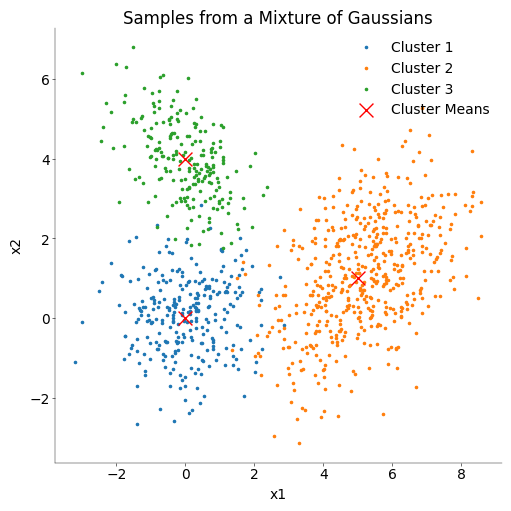

In [16]:
# ----------------------------------------------
# plot points from mixture of Gaussians (1 pt)
# ----------------------------------------------

fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")
colors = ["tab:blue", "tab:orange", "tab:green"]

# plot the samples
for k in range(3):
    idx = labels == k
    ax.scatter(x[idx, 0], x[idx, 1], s=10, color=colors[k], label=f"Cluster {k+1}")

# plot the means
ax.scatter(m[:, 0], m[:, 1], c="red", marker="x", s=100, label="Cluster Means")

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Samples from a Mixture of Gaussians")
ax.legend(loc="upper right")
plt.show()

## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `fit_mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 6 pts*


In [17]:
def fit_mog(
    x: np.ndarray,
    n_clusters: int,
    n_iters: int = 10,
    random_seed: int = 0,
    init: str = "random",
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Fit Mixture of Gaussian model using EM algo.

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    n_clusters: int
        Number of clusters

    n_iters: int
        Maximal number of iterations.

    random_seed: int
        Random Seed


    Returns
    -------

    labels: np.array, (n_samples)
        Cluster labels

    m: list or np.array, (n_clusters, n_dims)
        Means

    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    """
    # ensure reproducibility using a random number generator
    rng = np.random.default_rng(random_seed)
    n_samples, n_dims = x.shape

    # -----------
    # init (1 pt)
    # -----------
    if init == "random":
        # Randomly assign each point to a cluster
        labels = rng.integers(low=0, high=n_clusters, size=n_samples)
    elif init == "kmeans":
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed).fit(x)
        labels = kmeans.labels_
    else:
        raise ValueError("no valid init method was choosen")

    # initialize means, covariances, and priors
    m = np.array(
        [
            (
                x[labels == k].mean(axis=0)
                if np.any(labels == k)
                else rng.normal(size=n_dims)
            )
            for k in range(n_clusters)
        ]
    )
    S = np.array(
        [
            np.cov(x[labels == k].T) if np.any(labels == k) else np.eye(n_dims)
            for k in range(n_clusters)
        ]
    )

    # priors of clusters
    p = np.array([np.mean(labels == k) for k in range(n_clusters)])
    # posteriors of datapoints: Soft assignments to clusters
    r = np.zeros((n_samples, n_clusters))

    # -------------------------
    # EM maximisation (3 pts)
    # -------------------------

    for step in range(n_iters):
        # E step
        # Evaluate the posterior probablibities `r`
        # using the current values of `m`, `S` and 'p'
        for cluster, (mean, std, prior) in enumerate(zip(m, S, p)):
            r[:, cluster] = prior * sp.stats.multivariate_normal(mean, std).pdf(x)

        # normalizing
        r /= r.sum(axis=1, keepdims=True)
        # effective number of points per cluster
        N_k = r.sum(axis=0)

        # M step
        # estimate new `m`, `S` and `p`
        m = (r.T @ x) / N_k[:, np.newaxis]

        # estimate new `S`
        S = np.zeros((n_clusters, n_dims, n_dims))
        for k in range(n_clusters):
            x_centered = x - m[k]
            S[k] = (r[:, k][:, np.newaxis] * x_centered).T @ x_centered
            S[k] /= N_k[k]
        # estimate new `p`
        p = N_k / n_samples

    labels = np.argmax(r, axis=1)

    return labels, m, S, p

Run Mixture of Gaussian on toy data

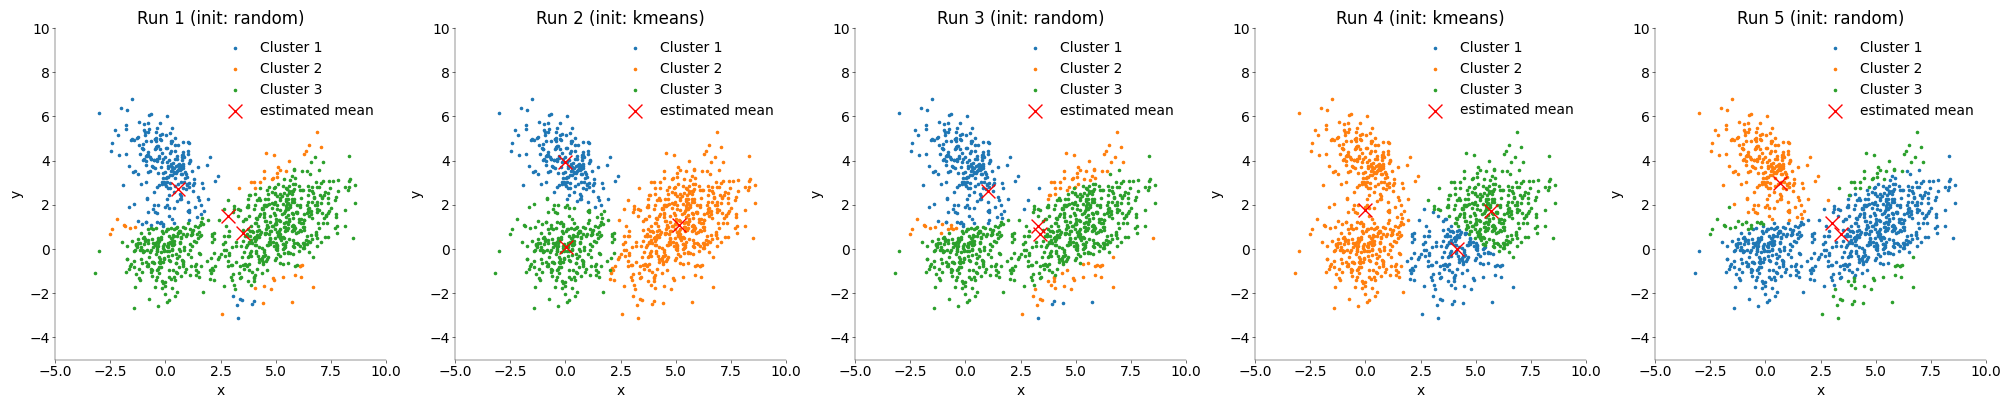

In [18]:
# -------------------------------------------------------------------------
# Run the algorithm 5 times on the toy data, plot and compare original and
# assigned clusters and answer the questions (1+1 pts)
# -------------------------------------------------------------------------

# initialize parameters
n_clusters = 3
n_iters = 10
random_seed = 0
n_runs = 5
labels_list = []
means_list = []
covs_list = []
priors_list = []
init = "random"
init_list = []
# run gmm 5 times
for i in range(n_runs):
    labels, means, covs, priors = fit_mog(x, n_clusters, n_iters, random_seed + i, init)
    labels_list.append(labels)
    means_list.append(means)
    covs_list.append(covs)
    priors_list.append(priors)
    init_list.append(init)
    # alternate between random and kmeans initialization
    init = "random" if init == "kmeans" else "kmeans"
# plot the results
fig, axs = plt.subplots(1, n_runs, figsize=(20, 5), layout="constrained")
for i in range(n_runs):
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("y")
    axs[i].set_xlim(-5, 10)
    axs[i].set_ylim(-5, 10)
    axs[i].set_aspect("equal")
    for k in range(n_clusters):
        idx = labels_list[i] == k
        axs[i].scatter(
            x[idx, 0],
            x[idx, 1],
            s=10,
            color=colors[k],
            label=f"Cluster {k+1}",
        )
    # plot the means
    axs[i].scatter(
        means_list[i][:, 0],
        means_list[i][:, 1],
        c="red",
        s=100,
        marker="x",
        label="estimated mean",
    )
    # legend in upper right corner
    axs[i].legend(loc="upper right")
    axs[i].set_title(f"Run {i+1} (init: {init_list[i]})")
plt.show()

### Questions

1) Do all runs converge to good solutions? If not, which one would you pick (only visual inspection required) as the best one?
 
No, not all runs converge to optimal solutions. Only the second run finds a nearly optimal solution. 

2) Do you get the same colors (=labels) in your best assignment(s) compared to the groundtruth? Does it have to be that way or not? Why?

No, I do not always get the same color assignments and it does also not matter which color each cluster has, as long as the clusters match the different gaussian distributions from the data sampling.

## Bonus Task (Optional): Mixture of drifting t-distributions

Instead of a simple Gaussian Mixture Model, more advanced algorithms can be implemented.
Implement a basic version of the mixture of drifting t-distributions (follow https://github.com/aecker/moksm/blob/master/MoT_Kalman.pdf).
What is the advantage of that method?

_Grading: 2 BONUS Points._


_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

In [ ]:
from scipy.stats import multivariate_t

def fit_mot(
    x: np.ndarray,
    n_clusters: int,
    n_iters: int = 10,
    df: float = 5.0,  # degrees of freedom for t-distribution
    drift_scale: float = 0.01,
    random_seed: int = 0,
    init: str = "random",
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Fit a Mixture of Drifting t-Distributions using EM-like algorithm."""

    rng = np.random.default_rng(random_seed)
    tol = 1e-6
    n_samples, n_dims = x.shape

    # --- Initialization ---
    if init == "random":
        cluster_ids = rng.integers(0, n_clusters, size=n_samples)
    elif init == "kmeans":
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed).fit(x)
        cluster_ids = kmeans.labels_

    m = np.array(
        [
            (
                np.mean(x[cluster_ids == i], axis=0)
                if np.any(cluster_ids == i)
                else rng.normal(size=n_dims)
            )
            for i in range(n_clusters)
        ]
    )

    S = np.array(
        [
            (
                np.cov(x[cluster_ids == i].T) + tol * np.eye(n_dims)
                if np.any(cluster_ids == i)
                else np.eye(n_dims)
            )
            for i in range(n_clusters)
        ]
    )

    p = np.array([np.sum(cluster_ids == i) / n_samples for i in range(n_clusters)])
    LLs = [-np.inf]

    for step in range(n_iters):
        # --- Drift Step (approximate drift with Kalman filter update) ---
        m += rng.normal(scale=drift_scale, size=m.shape)

        # --- E-Step ---
        responsibilities = np.zeros((n_clusters, n_samples))
        for k in range(n_clusters):
            rv = multivariate_t(loc=m[k], shape=S[k], df=df)
            responsibilities[k] = p[k] * rv.pdf(x)

        weighted_likelihoods = responsibilities.copy()
        responsibilities /= np.sum(responsibilities, axis=0) + 1e-12
        cluster_ids = np.argmax(responsibilities, axis=0)

        # --- M-Step ---
        for k in range(n_clusters):
            weights = responsibilities[k]
            total_weight = np.sum(weights)

            # update mean
            m[k] = np.sum(weights[:, None] * x, axis=0) / total_weight

            # update robust and drifiting covariance
            diff = x - m[k]
            S[k] = (weights[:, None, None] * np.einsum("ni,nj->nij", diff, diff)).sum(
                axis=0
            )
            S[k] /= total_weight
            S[k] += tol * np.eye(n_dims)

        # update priors
        p = np.sum(responsibilities, axis=1)
        p /= n_samples

        # log-likelihood
        LL = np.sum(np.log(np.sum(weighted_likelihoods, axis=0) + 1e-12))
        print(f"Iteration {step+1}: Log Likelihood = {LL:.6f}")

        if np.abs(LL - LLs[-1]) < tol:
            break
        LLs.append(LL)

    cluster_ids = np.argmax(responsibilities, axis=0)
    return cluster_ids, m, S, p

Iteration 1: Log Likelihood = -4143.774447
Iteration 2: Log Likelihood = -4165.198643
Iteration 3: Log Likelihood = -4180.076363
Iteration 4: Log Likelihood = -4191.332949
Iteration 5: Log Likelihood = -4199.699812
Iteration 6: Log Likelihood = -4202.543766
Iteration 7: Log Likelihood = -4204.348207
Iteration 8: Log Likelihood = -4207.615169
Iteration 9: Log Likelihood = -4211.175451
Iteration 10: Log Likelihood = -4211.942052
Iteration 11: Log Likelihood = -4210.606429
Iteration 12: Log Likelihood = -4212.992952
Iteration 13: Log Likelihood = -4212.961772
Iteration 14: Log Likelihood = -4214.827191
Iteration 15: Log Likelihood = -4214.864026
Iteration 16: Log Likelihood = -4215.836968
Iteration 17: Log Likelihood = -4217.252210
Iteration 18: Log Likelihood = -4214.962110
Iteration 19: Log Likelihood = -4212.605551
Iteration 20: Log Likelihood = -4212.073768


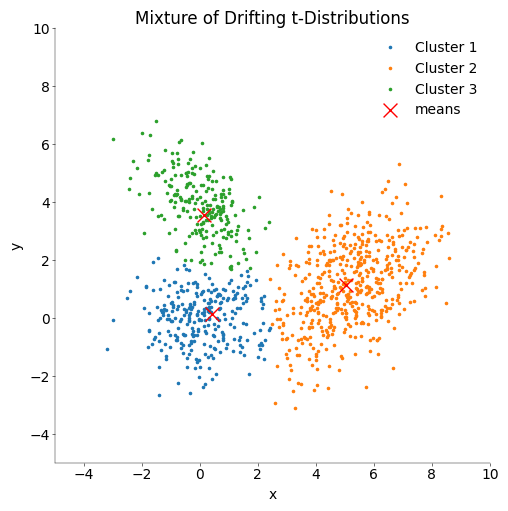

In [20]:
labels, means, covs, weights = fit_mot(
    x, n_clusters=3, n_iters=20, df=4, drift_scale=0.05, init="kmeans"
)

# Plot the results
fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")
ax.set_title("Mixture of Drifting t-Distributions")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(-5, 10)
ax.set_ylim(-5, 10)
ax.set_aspect("equal")
for k in range(n_clusters):
    idx = labels == k
    ax.scatter(
        x[idx, 0],
        x[idx, 1],
        s=10,
        color=colors[k],
        label=f"Cluster {k+1}",
    )
ax.scatter(
    means[:, 0],
    means[:, 1],
    c="red",
    s=100,
    marker="x",
    label="means",
)
ax.legend()
plt.show()

1) What is the advantage of the drifting t-distribution?

By modelling the drift of the distributions according to a Kalman filter update, we can approximate movements of the recording electrodes. Hence, possible changes in the recordings due to movement are being addressed and are accounted for. Because of the drift the LL may also increase at times, therefore, the EM-algorithm is not strictly converging anymore.

## Task 3: Model complexity
A priori we do not know how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 5 pts*



### Question (0.5 pts)

1) What is the number of parameters of the model?

Let:
- `K`: Number of Gaussian components
- `D`: Dimensionality of the data

#### For **full covariance matrix**:

```
Total = K * D + [D(D+1)]/2 + (K - 1)
```


In [21]:
def mog_bic(
    x: np.ndarray, m: np.ndarray, S: np.ndarray, p: np.ndarray
) -> tuple[float, float]:
    """Compute the BIC for a fitted Mixture of Gaussian model

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    m: np.array, (n_clusters, n_dims)
        Means

    S: np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.array, (n_clusters, )
        Cluster weights / probablities

    Return
    ------
    bic: float
        BIC

    LL: float
        Log Likelihood
    """

    # -------------------------
    # implement the BIC (1.5 pts)
    # -------------------------
    (n_samples, n_dims), n_clusters = x.shape, m.shape[0]
    likelihoods = np.zeros((n_clusters, n_samples))

    for i, prior in enumerate(p):
        likelihoods[i] = prior * sp.stats.multivariate_normal.pdf(x, m[i], S[i])

    log_likelihood = np.log(likelihoods.sum(axis=0)).sum()

    # compute number of parameters
    n_parameters = (
        n_clusters * n_dims
        + n_clusters * (n_dims * (n_dims + 1)) / 2
        + (n_clusters - 1)
    )

    # compute BIC
    bic = -2 * log_likelihood + n_parameters * np.log(n_samples)

    return bic, log_likelihood

In [27]:
# ----------------------------------------------------------------------------------------------------------------------
# Compute and plot the BIC for mixture models with different numbers of clusters (e.g., 2 - 6). (0.5 pts)
# Make your _estimate of the BIC_ robust against local minima, regardless of the initialization strategy used (0.5 pts)
# ----------------------------------------------------------------------------------------------------------------------

K = np.arange(2, 10, dtype=int)
num_seeds = 50

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# Run with different seeds each number of clusters
for seed_idx, seed in enumerate(range(num_seeds)):
    for k_idx, k in enumerate(K):
        # Fit the model
        labels, m_pred, S_pred, p_pred = fit_mog(
            x, k, n_iters=20, random_seed=seed, init="random"
        )

        # Calculate log-likelihood and BIC
        BIC[seed_idx, k_idx], LL[seed_idx, k_idx] = mog_bic(x, m_pred, S_pred, p_pred)

# Compute the best BIC for each number of clusters
best_bic = np.min(BIC, axis=0)
best_seed_idx = np.argmin(BIC, axis=0)

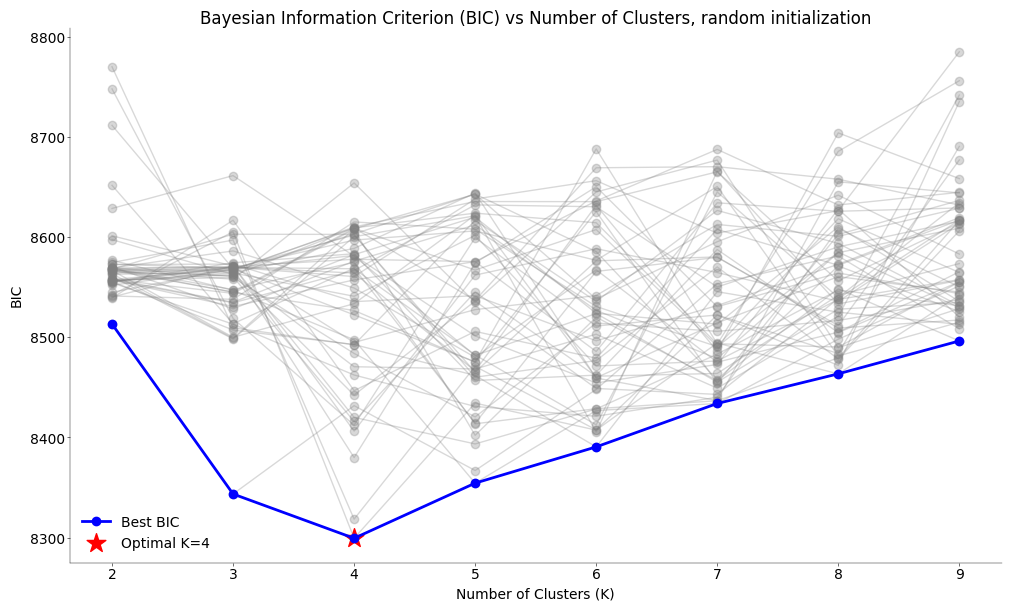

In [28]:
# ------------------------------------------------------------------------------------------
# Plot the result and answer the questions (1+1 pts)
# Don't forget to plot your robust estimate and highlight the estimated number of clusters!
# ------------------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10, 6))

# individual runs
for seed_idx in range(num_seeds):
    ax.plot(K, BIC[seed_idx], "o-", alpha=0.3, color="gray")

# best BIC
ax.plot(K, best_bic, "o-", linewidth=2, color="blue", label="Best BIC")

# minimum BIC
optimal_k_idx = np.argmin(best_bic)
optimal_k = K[optimal_k_idx]
ax.scatter(
    optimal_k,
    best_bic[optimal_k_idx],
    s=200,
    color="red",
    marker="*",
    label=f"Optimal K={optimal_k}",
)

ax.set_xticks(K)
ax.set_xlabel("Number of Clusters (K)")
ax.set_ylabel("BIC")
ax.set_title(
    "Bayesian Information Criterion (BIC) vs Number of Clusters, random initialization"
)
ax.legend()

plt.show()

### Questions

1) What happens to the BIC if the model got stuck in a local minimum? For your reasoning, you can also refer to Task 2.

The model with this seed shows a higher increase in BIC for that number of clusters (K) than all the other seeds for that parameter combination. For a fixed k, only the likelihood differs. While there are always small variances in likelihoods with different seeds, a local minimum results in this likelihood varying in a completely different range, as the small differences from different seeds effect completely different datapoints changing cluster assignment, as can be seen in Task 2.

2) The goal is to estimate which number of clusters best fits the data using the BIC. Therefore, what qualifies as a robust estimate? Explain your reasoning!
   
_(Hint: think about which number of cluster you would use and why)_

Generally, the log-likelihood is a robust estimate, yet this can lead to overfitting which the BIC is supposed to take care of. To get a robust estimate we could multiply the LL by the number of clusters. A low value would be favorable. Hence, a high number of variables would be punished but at the same time a good fit is rewarded.

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (MoG fitting + model complexity selection).

Show the plot of the BIC as a function of the number of mixture components on the real data, highlight the robust estimate and based on that the best number of clusters.

For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot.

*Grading: 3 pts*


In [29]:
# -------------------------------------------------------------
# Run the algorithm on the set of extracted features (0.5 pts)
# -------------------------------------------------------------

K = np.arange(2, 16)
num_seeds = 10

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# run multiple trials for each number of clusters
for seed_idx, seed in enumerate(range(num_seeds)):
    for k_idx, k in enumerate(K):
        # fit the model
        labels, means, covs, weights = fit_mog(
            b, k, n_iters=20, random_seed=seed, init="kmeans"
        )

        # compute BIC
        bic, ll = mog_bic(b, means, covs, weights)
        BIC[seed_idx, k_idx] = bic
        LL[seed_idx, k_idx] = ll

# compute the best BIC for each number of clusters
best_bic = np.min(BIC, axis=0)
best_seed_idx = np.argmin(BIC, axis=0)

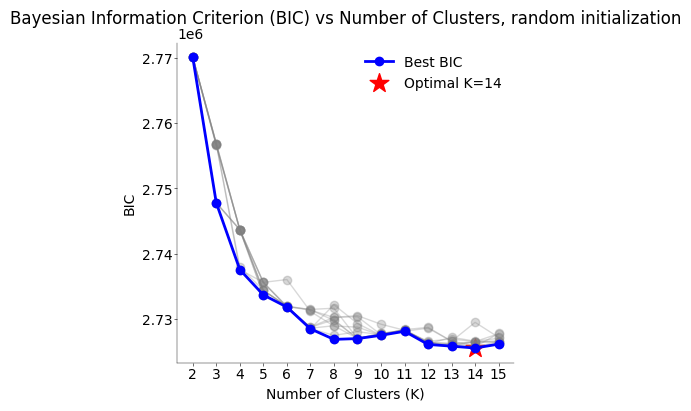

In [30]:
# ----------------------------------------------------------------------------------------------------------------------
# Plot the BIC over number of mixture components and highlight robust estimate and optimal number of clusters (0.5 pts)
# ----------------------------------------------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(4, 4))

# individual runs
for seed_idx in range(num_seeds):
    ax.plot(K, BIC[seed_idx], "o-", alpha=0.3, color="gray")

# best BIC
ax.plot(K, best_bic, "o-", linewidth=2, color="blue", label="Best BIC")

# minimum BIC
optimal_k_idx = np.argmin(best_bic)
optimal_k = K[optimal_k_idx]
ax.scatter(
    optimal_k,
    best_bic[optimal_k_idx],
    s=200,
    color="red",
    marker="*",
    label=f"Optimal K={optimal_k}",
)

ax.set_xticks(K)
ax.set_xlabel("Number of Clusters (K)")
ax.set_ylabel("BIC")
ax.set_title(
    "Bayesian Information Criterion (BIC) vs Number of Clusters, random initialization"
)
ax.legend()
plt.show()

Refit model with lowest BIC and plot data points

In [31]:
random_seed, kk = np.where(BIC == BIC.min())
random_seed = random_seed[0]
kk = kk[0]
print(f"lowest BIC: # cluster = {K[kk]}")
# fit the model with the optimal number of clusters
a, m, S, p = fit_mog(b, K[kk], random_seed=random_seed, init="kmeans")

lowest BIC: # cluster = 14


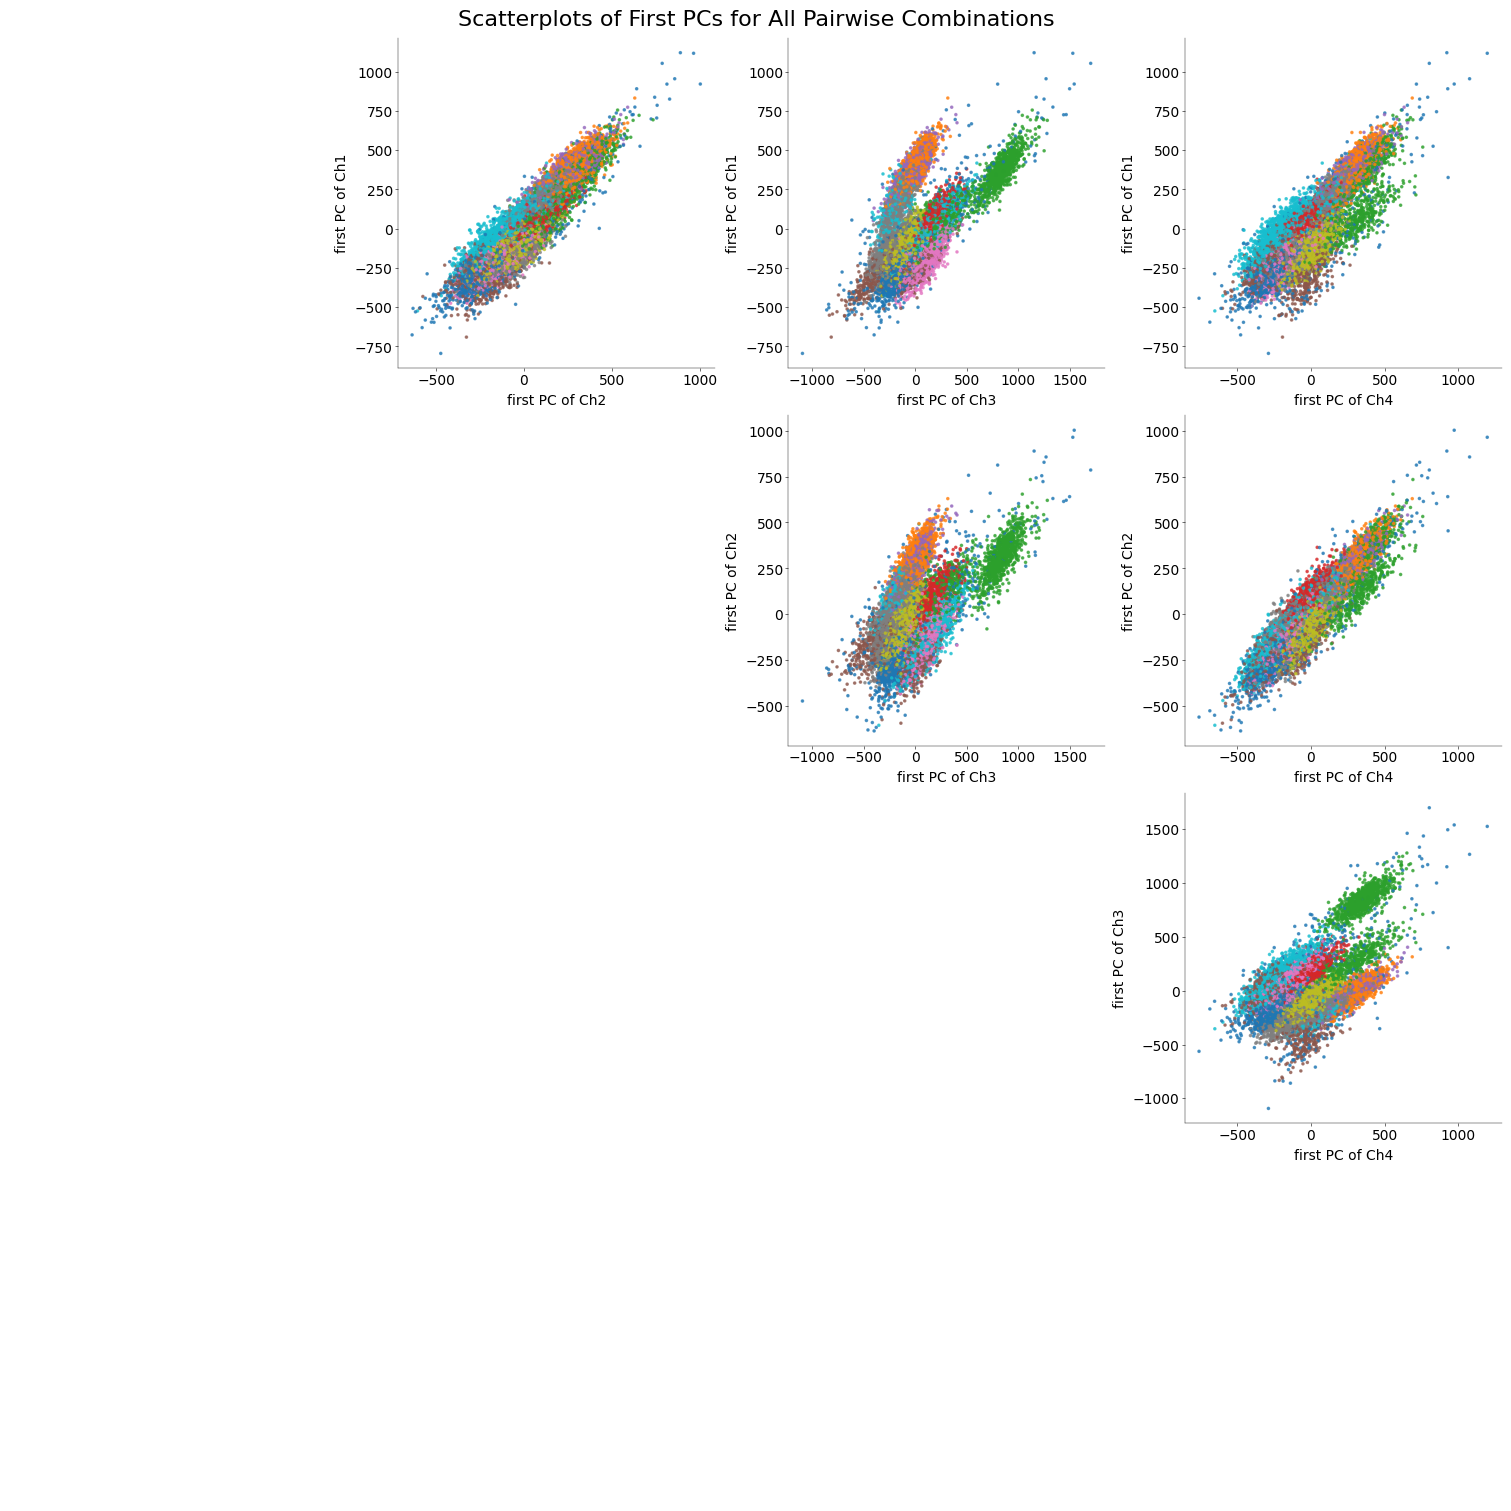

In [32]:
# ------------------------------------------------------------------------------------------------------------------
# Create scatterplots of the first PCs under the best model for all pairwise combinations of the 4 channels. (1 pt)
# ------------------------------------------------------------------------------------------------------------------

# index of the 1st PC in `b`
idx_1stPC = {"Ch1": 0, "Ch2": 3, "Ch3": 6, "Ch4": 9}

fig, axes = plt.subplots(4, 4, figsize=(15, 15), constrained_layout=True)

# iterate over all pairwise combinations of the 4 channels
for i, cha in enumerate(idx_1stPC.keys()):
    for j, chb in enumerate(idx_1stPC.keys()):
        if i < j:
            ax = axes[i, j]
            ax.scatter(
                b[:, idx_1stPC[chb]],
                b[:, idx_1stPC[cha]],
                c=labels,
                cmap="tab10",
                s=10,
                alpha=0.7,
            )
            ax.set_xlabel("first PC of " + chb)
            ax.set_ylabel("first PC of " + cha)

        else:
            axes[i, j].axis("off")  # Turn off diagonal plots and double plots

plt.suptitle("Scatterplots of First PCs for All Pairwise Combinations", fontsize=16)
plt.show()

## Task 5: Cluster separation and Correlograms

As postprocessing, implement the calculation of auto- and cross correlograms over the spike times.

Plot the (auto-/cross-) correlograms, displaying a time frame of -30ms to +30ms. Choose a good bin size and interprete the resulting diagrams.

_Grading: 3 pts_

#### Hints

_It is faster to calculate the histogram only over the spiketimes that are in the displayed range. Filter the spike times before calculating the histogram!_

_For the autocorrelogram, make sure not to include the time difference between a spike and itself (which would be exactly 0)_

_For the correlogram an efficient implementation is very important - looping over all spike times is not feasible. Instead, make use of numpy vectorization and broadcasting - you can use functions such as tile or repeat._

In [33]:
# ----------------------------------------------------------------------
# Implement a function for calculating the spike time differences (1pt)
# ----------------------------------------------------------------------
def cross_time_diff(spiketimes1: np.ndarray, spiketimes2: np.ndarray) -> np.ndarray:
    """Compute the pairwise time differences between two sets of spike times.

    Parameters
    ----------
    spiketimes1: np.ndarray, (n_spikes1, )
        Spike times of the first cluster
    spiketimes2: np.ndarray, (n_spikes2, )
        Spike times of the second cluster

    Return
    ------

    time_diff: np.ndarray, (n_spikes1, n_spikes2)
        Pairwise time differences between the two sets of spike times
        (i.e., spiketimes1[i] - spiketimes2[j])
    """
    return spiketimes1[:, np.newaxis] - spiketimes2[np.newaxis, :]

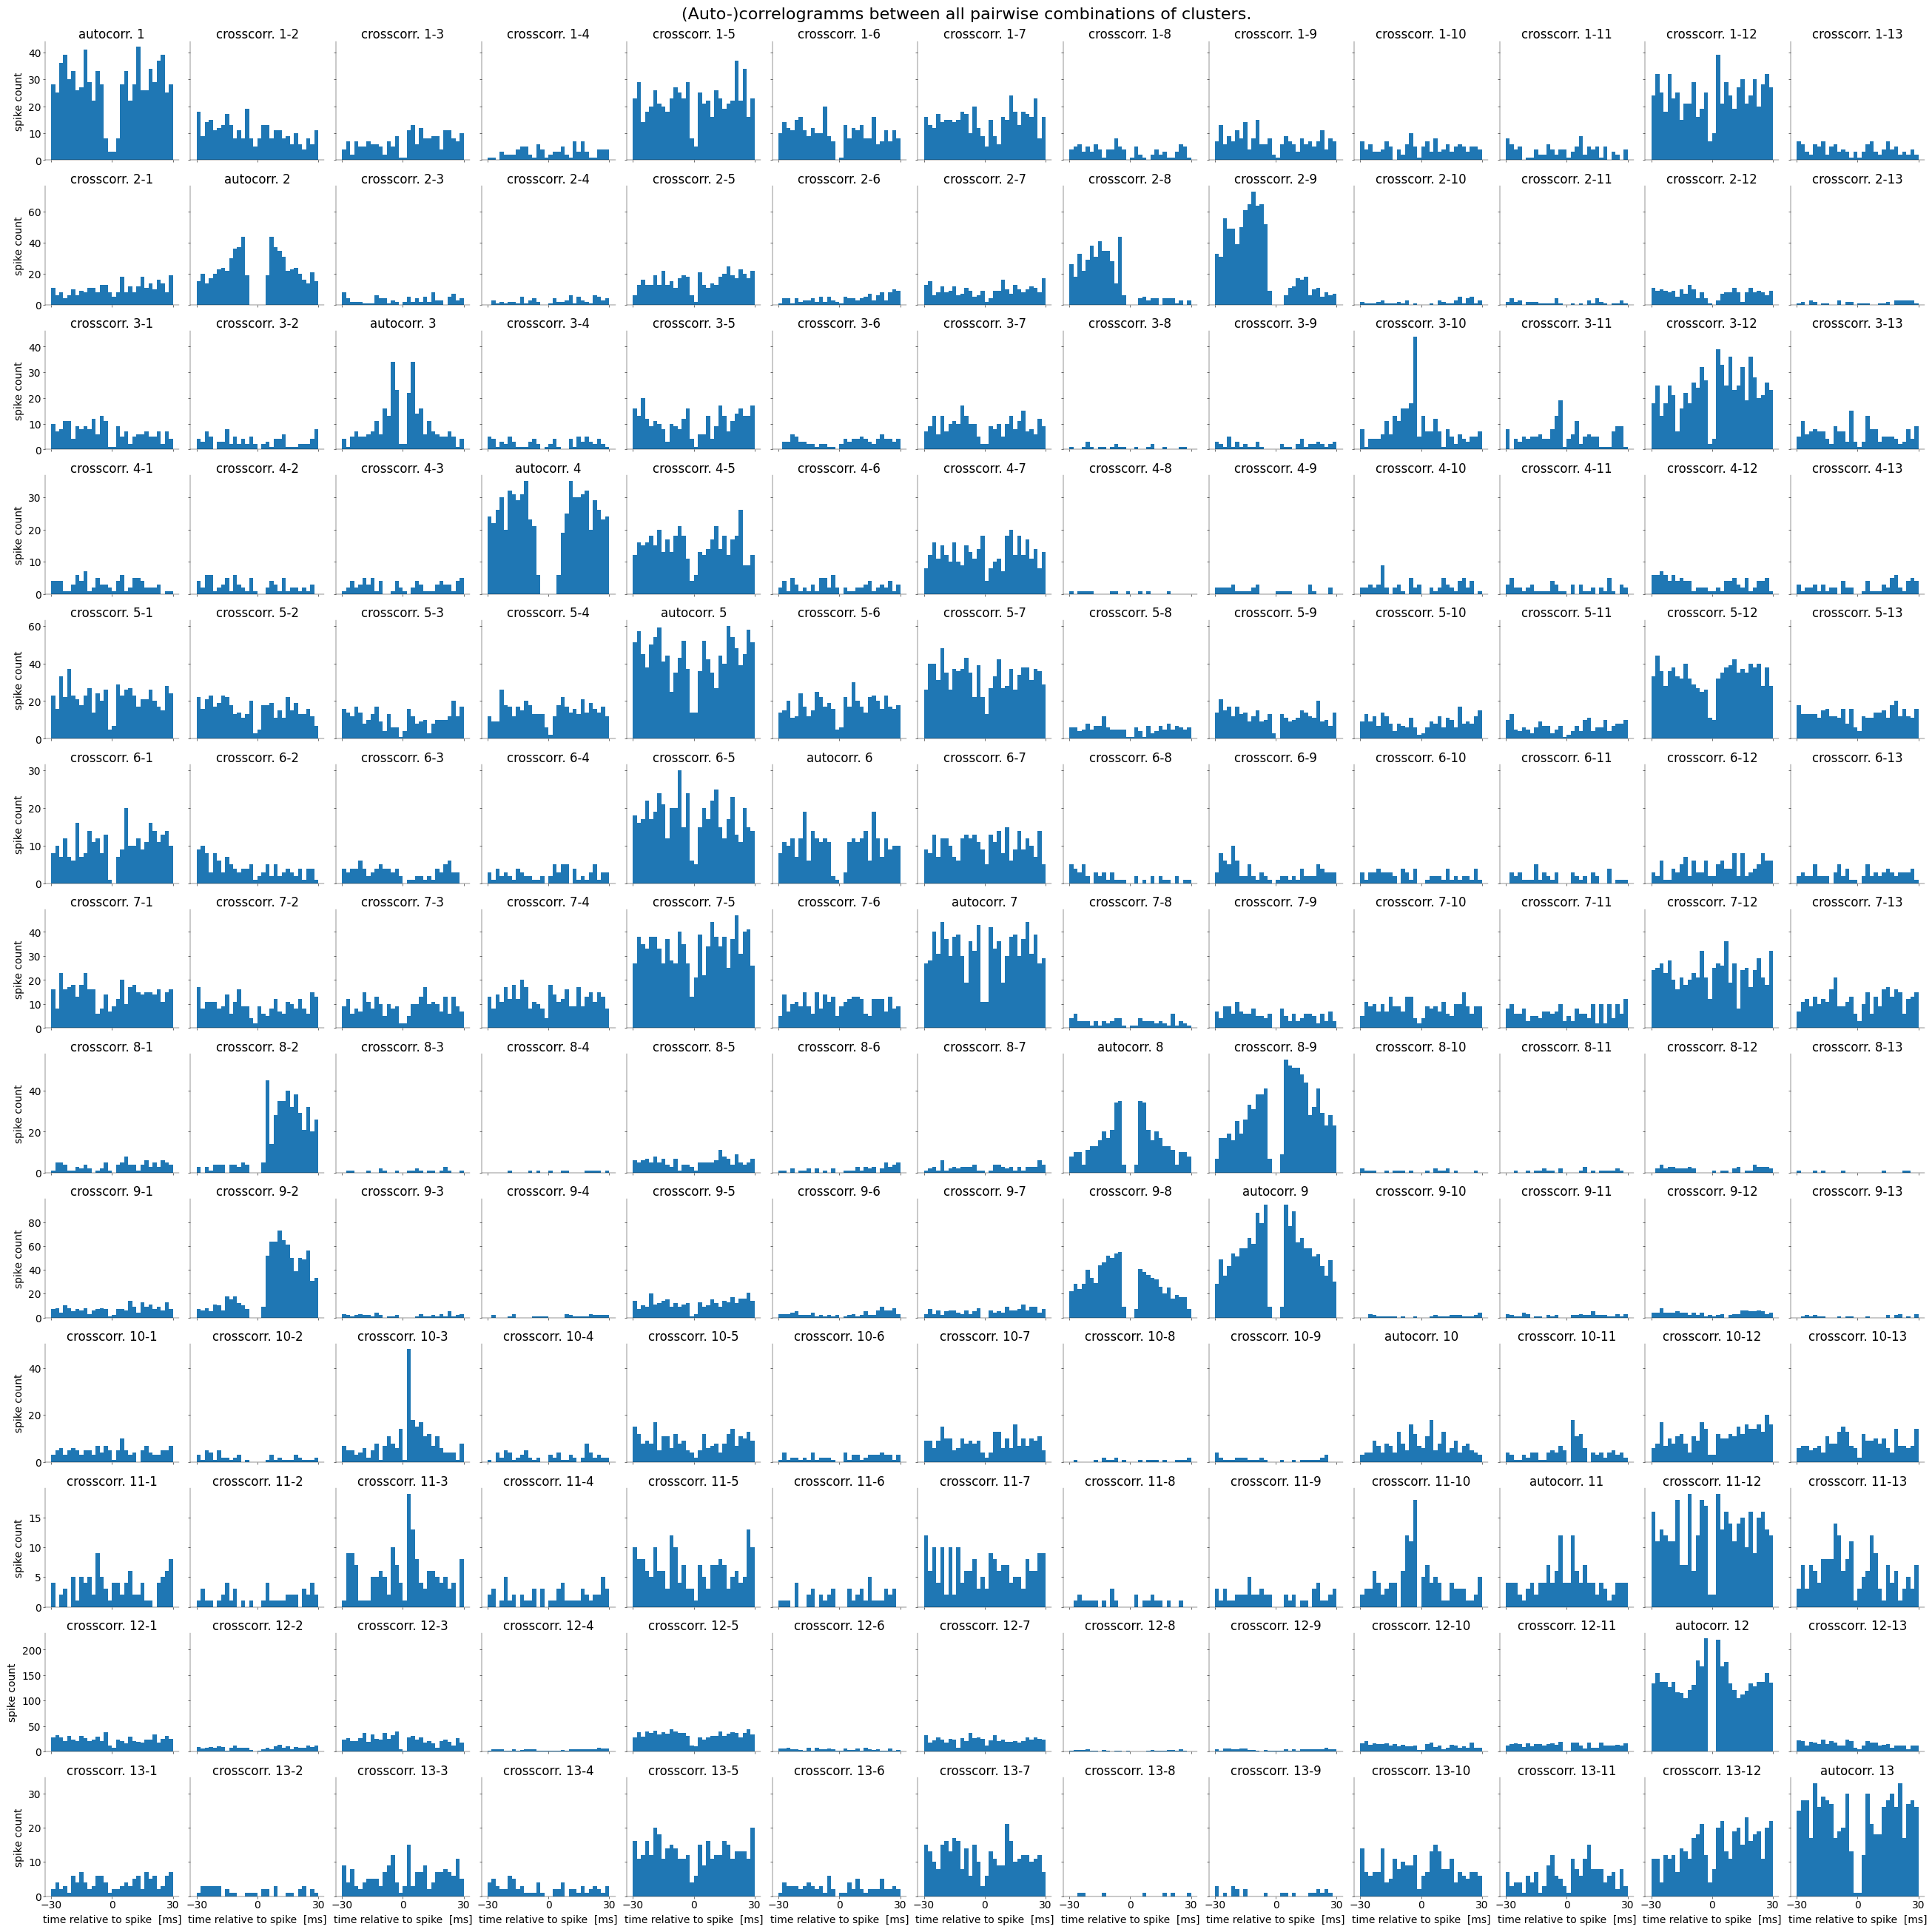

In [35]:
# -----------------------------------------------------------------------------------
# Calculate and plot auto- and cross correlograms and answer the questions (1+1 pts)
# -----------------------------------------------------------------------------------

n_clusters = a.max()
fig, axes = plt.subplots(
    K[kk] - 1,
    K[kk] - 1,
    figsize=(26, 26),
    constrained_layout=True,
    sharex=True,
    sharey="row",
)

for c1 in range(n_clusters):
    for c2 in range(n_clusters):
        ax = axes[c1, c2]
        # get spike times
        t1, t2 = t[a == c1], t[a == c2]
        # pairwise time differences
        time_diff = cross_time_diff(t1, t2)

        # find all spike pairs within 30ms of each other...
        if c1 != c2:  # cross-correlograms
            x, y = np.where(np.abs(time_diff) < 30.0)
        else:  # auto-correlograms, remove correlation of a spike with itself
            x, y = np.where((np.abs(time_diff) < 30.0) & (np.abs(time_diff) > 1e-5))

        # count & plot
        ax.hist(
            t1[x] - t2[y],
            bins=30,
            range=(
                -30.0,
                30.0,
            ),
        )

        # labeling
        ax.set_xticks([-30, 0, 30])

        if c1 == c2:
            ax.set_title(f"autocorr. {c1+1}")
        else:
            ax.set_title(f"crosscorr. {c1+1}-{c2+1}")

        if c2 == 0:
            ax.set_ylabel("spike count")
        if c1 == n_clusters - 1:
            ax.set_xlabel("time relative to spike  [ms]")

plt.suptitle(
    "(Auto-)correlogramms between all pairwise combinations of clusters.", fontsize=16
)
plt.show()

### Questions
1) Based on the plot, do you see clusters that contain spikes likely from a single neuron?

Look for autocorrelograms (diagonal elements) with:

A clear refractory period: a visible dip near 0 ms, often within ±2 ms, suggesting a neuron cannot fire again immediately.
A sharp peak at 0 followed by decaying symmetry.

From the image, examples of clean single-unit-like autocorrelograms include:

Cluster 0: Clear refractory period and decaying symmetry.   
Cluster 7: Prominent center peak and sharp drop-off—classic single-unit.   
Cluster 10 and Cluster 11: Similar well-defined refractory dips.   

2) Do you see cases where plural clusters might come from the same neuron?

Check cross-correlograms (off-diagonal) for:

A strong central peak between two clusters, suggesting coincident or overlapping firing patterns.   
Symmetry or consistent lag that reflects one cluster possibly splitting a neuron’s activity.   

Examples suggesting duplicate clusters:

Cluster 10 & 11: High cross-correlation around 0 ms.   
Cluster 0 & 1: Significant central peak, though less clear.   
Cluster 7 & 8: Strong correlation—possible overclustering.   

3) Do you see clusters that might contain spikes from plural neurons?

This usually shows in autocorrelograms as:

Lack of a refractory period.   
Multiple peaks or uniform distribution.   
Broad central peaks or high baseline noise. 

Possible multi-unit clusters:

Cluster 13: Flat autocorrelogram with no dip—indicative of overlapping spikes.   
Cluster 4: Broad central region, no clear refractory trough.   
Cluster 12: High firing rate and lack of structure.   

4) Explain the term "refractory period" and how one can see it in this plot.

Refractory period of a neuron means the time after a spike, during which a neuron can't send another spike due to its physiological constraints. In the autocorrelation plot of clusters 1,3,5 this can be clearly seen as a through in the spike count around 0, as there are no spikes with a timedifference shorter than the refractory period in the neuron represented by one of these clusters.